In [1]:
#import tensorflow as tf 
# https://sci-hub.se/10.1002/sim.1203
# https://journals.sagepub.com/doi/pdf/10.1177/1536867x0900900206

# Dataset

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

from sksurv.metrics import concordance_index_censored
from lifelines.datasets import load_rossi

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

In [ ]:
X = data.drop(columns=[event_col, duration_col])
X.shape

# Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    range(data.shape[0]), test_size=0.15, random_state=42, stratify=data[event_col]
)
# Data splits
data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
print(data_train.shape, data_test.shape)

# Feature matrix splits 
X_train, X_test = X.iloc[train_idx].values, X.iloc[test_idx].values

# Pre-processing

In [ ]:
from sksurv.util import Surv

event_col = "arrest"
duration_col = "week"

event_test = data_test[event_col].values
event_train = data_train[event_col].values

duration_test = data_test[duration_col].values
duration_train = data_train[duration_col].values

y_test = Surv.from_arrays(event=event_test.squeeze(), time=duration_test.squeeze())
y_train = Surv.from_arrays(event=event_train.squeeze(), time=duration_train.squeeze())

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model

In [ ]:
from utils.model import Model

model = Model(epochs=1)
model.fit(X_train, y_train)

# Coefficient at initialization 
from utils.data import init_params_cox
beta, _ = init_params_cox(model.D, X_train, duration_train, event_train)

# Baseline 
print(concordance_index_censored(event_train.astype(bool), duration_train, (X_train @ beta.T).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, (X_test @ beta.T).squeeze()))

In [66]:
model = Model(epochs=10, learning_rate=0.01)
model.fit(X_train, y_train)

# Fitted model 
print(concordance_index_censored(event_train.astype(bool), duration_train, model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, model.risk_score(X_test).squeeze()))

(0.6336345609986023, 19475, 11253, 35, 1080)
(0.6219768664563617, 591, 359, 1, 0)


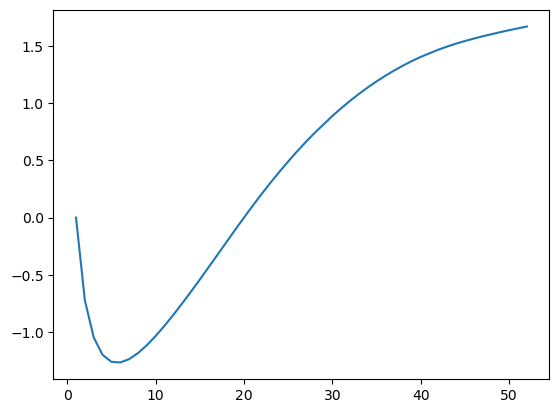

In [34]:
Sb = model.baseline_survival(duration)

idx = np.argsort(duration)

plt.figure()
plt.plot(duration[idx], Sb[idx, 0])

In [59]:
import numpy as np
S0 = model.survival_curve(X.values[0], duration)
S1 = model.survival_curve(X.values[1], duration)

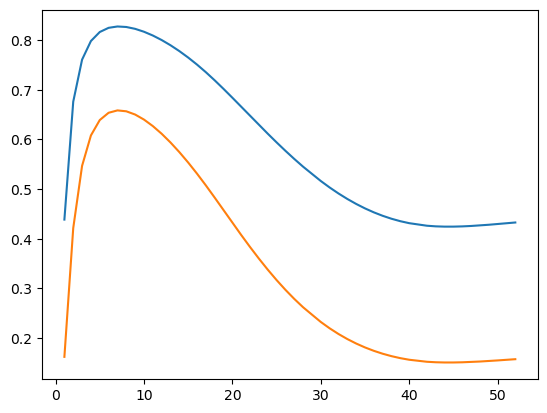

In [60]:
idx = np.argsort(duration)

plt.figure()
plt.plot(duration[idx], S0[idx, 0])
plt.plot(duration[idx], S1[idx, 0])

# Initialize clients

In [5]:
N_CLIENTS = 3
CLIENT_DATA_IDX = np.array_split(np.arange(X.shape[0]), N_CLIENTS)

clients = []
for i, idx in enumerate(CLIENT_DATA_IDX):
    participant = Client(cid=i, data=X.iloc[idx], times=times[idx], delta=delta[idx])
    participant.train_test_split()
    clients.append(participant)

# Initialize parameters

In [6]:
# Knot locations: Centiles of the distribution of **uncensored** log event times
# - Boundary knots: placed at the 0th and 100th centiles (min and max values)
# - Internal knots: internal knots are placed at the centiles between the min and max   
knots = np.percentile(np.log(times[delta.astype(int) == 1]), [0, 25, 50, 75, 100])
# NOTE (lifelines method): knots = np.percentile(T[E.astype(bool).values], np.linspace(5, 95, self.n_baseline_knots + 1))
knots

array([4.82831374, 6.58822688, 7.09506438, 7.91221465, 8.8797508 ])

In [7]:
for participant in clients:
    # Distribute the same knot positions to every client 
    participant.initialize_params(knots.copy())
    print(participant.gradient_gamma())

[[ 277746.8368778  -237851.48861074 -188399.93897627 -102147.85748215]]
[[ 522098.83731172 -182280.73960856 -143273.3637605   -77667.44574867]]
[[ 776.57319212 -421.23705102 -319.18196032 -168.84651303]]


# Initialize parameters

In [8]:
def average_parameters(clients):
    
    beta_avg, gamma_avg = 0, 0
    for participant in clients:
        
        beta_avg += participant.beta 
        gamma_avg += participant.gamma  

    beta_avg /= len(clients)
    gamma_avg /= len(clients)

    return beta_avg, gamma_avg


beta0, gamma0 = average_parameters(clients)
gamma0

array([[0.57690393, 0.26043959, 0.42902952, 0.95308014]])

In [9]:
for participant in clients:
    print(participant.gamma)
    participant.set_params(beta=beta0.copy(), gamma=gamma0.copy())
    print(participant.gamma)
    print()

[[0.94583029 0.08227539 0.334322   0.92837163]]
[[0.57690393 0.26043959 0.42902952 0.95308014]]

[[0.46720137 0.50336128 0.83790928 0.98520618]]
[[0.57690393 0.26043959 0.42902952 0.95308014]]

[[0.31768012 0.1956821  0.11485727 0.94566262]]
[[0.57690393 0.26043959 0.42902952 0.95308014]]



# Training 

In [10]:
def scores(clients, beta=None):

    all_train_scores, all_test_scores = [], []
    for participant in clients:
        train_score, test_score = participant.c_score(beta=beta)
        all_train_scores.append(train_score)
        all_test_scores.append(test_score)

    return all_train_scores, all_test_scores

In [11]:
# Baseline results (before any training)
from sksurv.metrics import concordance_index_censored

beta_avg0, gamma_avg0 = average_parameters(clients)

train_scores0, test_scores0 = scores(clients, beta=beta_avg0)
np.mean(train_scores0), np.mean(test_scores0)

(0.601579509554827, 0.4307273158019427)

In [12]:
# NOTE: difference between sending model weights to the server for aggregation or sending 
# weight gradients to the server 

_beta, _gamma = beta_avg0.copy(), gamma_avg0.copy()

for participant in clients:
    participant.set_params(beta=_beta, gamma=_gamma)


def learning_rate_sched(epoch, init_lr=0.01, total_epochs=10):
    return init_lr * 0.5 * (1 + np.cos(np.pi * epoch / total_epochs))


for epoch in range(20):

    learning_rate = learning_rate_sched(epoch)

    for participant in clients:
        participant.train_steps(local_steps=50, learning_rate=learning_rate)

    _beta, _gamma = average_parameters(clients)

    for participant in clients:
        participant.set_params(beta=_beta, gamma=_gamma)

train_scores, test_scores = scores(clients, beta=_beta)
np.mean(train_scores), np.mean(test_scores)

(0.7837164622981891, 0.6906499249782833)

In [ ]:
from utils.client import Client 

N_CLIENTS = 3 

data_idx = np.array_split(np.arange(data.shape[0]), N_CLIENTS)

participants = [] 
for idx in data_idx:
    # Mutually exclusive data samples 
    client = Client(data.iloc[idx], n_knots=5, n_epochs=5, event_col=event_col, duration_col=duration_col)
    
    # Apply data pre-processing
    client.preprocess_data()
    # Initialize model and parameters
    client.init_model()
    
    participants.append(client)

In [ ]:
# TODO:
#   - explicit gradients
#		- compare explicit gradients with scipy numerical differentiation
#		- should modify term “delta / ds_dt” into “delta / (1 + ds_dt)” to avoid zero division? 
#			- Is it numerically possible to have zero division there?
#	- fitting global vs local models 
#	- optimisation via GD and fedADMM (improving spline coefficients estimation)
#	- modelling on different scales (log cumulative and log hazard)